# Chat bots with python

This notebook contains a Keras implementation of the paper entitled: [End-To-End Memory Networks](https://arxiv.org/pdf/1503.08895.pdf) by Sainbayar Sukhbaatar et al. The idea is to train a Q&A chat bot by training an ANN using a data set of contexts for questions and answers.

In [2]:
import pickle
import numpy as np

with open('../../datasets/train_qa.txt', 'rb') as f:
    train_data = pickle.load(f)
    
with open('../../datasets/test_qa.txt', 'rb') as f:
    test_data = pickle.load(f)


In [3]:
train_size = len(train_data)
print(f"Train size: {train_size}")
print(f"Train examples:\n {train_data[:2]}")

Train size: 10000
Train examples:
 [(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.'], ['Is', 'Sandra', 'in', 'the', 'hallway', '?'], 'no'), (['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.', 'Mary', 'went', 'back', 'to', 'the', 'bedroom', '.', 'Daniel', 'went', 'back', 'to', 'the', 'hallway', '.'], ['Is', 'Daniel', 'in', 'the', 'bathroom', '?'], 'no')]


The input data corresponds to short stories (the context), followed by a question about the context, and finally the answer to that particular question. For example:

In [5]:
context = train_data[0][0]
question = train_data[0][1]
answer = train_data[0][2]
print(f"The context: {context}")
print(f"The question: {question}")
print(f"The answer: {answer}")

The context: ['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.']
The question: ['Is', 'Sandra', 'in', 'the', 'hallway', '?']
The answer: no


Now, let's construct a vocabulary from the data we have. Basically, we need to gather all the unique words from the three types of inputs.

In [37]:
all_data = train_data + test_data
vocab = set()
for context, question, answer in all_data:
    vocab = vocab.union(set(context))
    vocab = vocab.union(set(question))
    vocab = vocab.union({answer})
vocab_len = len(vocab) + 1 # Necessary for keras given how it pad sequences.

In [38]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

Let's explore the longest story/context, question and answers. This is important when defining the matrices that will be passed to keras.

In [39]:
story_lenghts = [len(data[0]) for data in all_data]
max_story_len = max(story_lenghts)

question_lenghts = [len(data[1]) for data in all_data]
max_question_len = max(question_lenghts)

answer_lenghts = [len(data[2]) for data in all_data]
max_answer_len = max(answer_lenghts)

In [40]:
print(f"Max story lenght: {max_story_len}")
print(f"Max question lenght: {max_question_len}")
print(f"Max answer lenght: {max_answer_len}")

Max story lenght: 156
Max question lenght: 6
Max answer lenght: 3


### Vectorize the input data

In [41]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)
tokenizer.word_index

{'mary': 1,
 'milk': 2,
 'is': 3,
 'the': 4,
 'went': 5,
 'kitchen': 6,
 '.': 7,
 'daniel': 8,
 'journeyed': 9,
 'no': 10,
 'grabbed': 11,
 'john': 12,
 'garden': 13,
 'discarded': 14,
 'sandra': 15,
 'got': 16,
 'travelled': 17,
 'yes': 18,
 'bathroom': 19,
 'hallway': 20,
 'put': 21,
 'bedroom': 22,
 'took': 23,
 'moved': 24,
 'football': 25,
 'to': 26,
 'picked': 27,
 'office': 28,
 'dropped': 29,
 'in': 30,
 'apple': 31,
 'left': 32,
 '?': 33,
 'down': 34,
 'there': 35,
 'up': 36,
 'back': 37}

Now we can prepare the training data using the trained tokenizer

In [42]:
train_story_text = []
train_question_text = []
train_answer_text = []

for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answer_text.append(answer)
    
train_story_seq = tokenizer.texts_to_sequences(train_story_text)
train_question_seq = tokenizer.texts_to_sequences(train_question_text)
train_answer_seq = tokenizer.texts_to_sequences(train_answer_text)

In [86]:
import numpy as np

def vectorize_stories(data, word_index, max_story_len, max_question_len):
    X = []
    Xq = []
    Y = []
    for story, question, answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in question]
        y = np.zeros(len(word_index) + 1)
        y[word_index[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y)

In [87]:
inputs_train, questions_train, answers_train = vectorize_stories(train_data, 
                                                                 tokenizer.word_index, 
                                                                 max_story_len, 
                                                                 max_question_len)

inputs_test, questions_test, answers_test = vectorize_stories(test_data, 
                                                                 tokenizer.word_index, 
                                                                 max_story_len, 
                                                                 max_question_len)

In [88]:
print(inputs_train.shape)
print(questions_train.shape)
print(answers_train.shape)

(10000, 156)
(10000, 6)
(10000, 38)


## Implement the ANN model

In [70]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

# Input of the stories, placeholder shape=(max_story_len, batch_size)
input_sequence = Input(shape=(max_story_len,))
question = Input(shape=(max_question_len,))

# vocab_len
vocab_size = len(vocab) + 1

# Input encoder M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))
# Output: (samples, story_maxlen, embedding_dim)

# Input encoder C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# Output: (samples, story_maxlen, max_question_len)

# Question encoder
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# Output: (samples, embedding_dim)

#######
# Encoder(Input) ----> Encoder, this is the result of the encoder
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

answer = concatenate([response, question_encoded])

In [71]:
question_encoded

<tf.Tensor 'sequential_12/dropout_14/cond/Identity:0' shape=(None, 6, 64) dtype=float32>

In [72]:
answer

<tf.Tensor 'concatenate_4/concat:0' shape=(None, 6, 220) dtype=float32>

In [73]:
question

<tf.Tensor 'input_8:0' shape=(None, 6) dtype=float32>

In [74]:
answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer) # (samples, vocab_size) # Yes/ No
answer = Activation("softmax")(answer)
model = Model([input_sequence, question], answer)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      multiple             2432        input_7[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 6, 64)        2432        input_8[0][0]                    
____________________________________________________________________________________________

In [76]:
answer

<tf.Tensor 'activation_7/Softmax:0' shape=(None, 38) dtype=float32>

In [79]:
answers_test[0]

array([list([1, 16, 4, 2, 35, 7, 12, 24, 26, 4, 22, 7])], dtype=object)

In [90]:
%%time
history = model.fit([inputs_train, questions_train], 
                    answers_train, 
                    batch_size=32, 
                    epochs=100, 
                    validation_data=([inputs_test, questions_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 2s 184us/step - loss: 0.6937 - accuracy: 0.5042 - val_loss: 0.6937 - val_accuracy: 0.4750
Epoch 2/100
10000/10000 [==============================] - 2s 180us/step - loss: 0.6929 - accuracy: 0.5083 - val_loss: 0.6940 - val_accuracy: 0.4860
Epoch 3/100
10000/10000 [==============================] - 2s 184us/step - loss: 0.6858 - accuracy: 0.5319 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 4/100
10000/10000 [==============================] - 2s 183us/step - loss: 0.6693 - accuracy: 0.5763 - val_loss: 0.6497 - val_accuracy: 0.6380
Epoch 5/100
10000/10000 [==============================] - 2s 183us/step - loss: 0.6232 - accuracy: 0.6660 - val_loss: 0.5904 - val_accuracy: 0.7150
Epoch 6/100
10000/10000 [==============================] - 2s 182us/step - loss: 0.5818 - accuracy: 0.7009 - val_loss: 0.5662 - val_accuracy: 0.7180
Epoch 7/100
10000/10000 [==============================] 

10000/10000 [==============================] - 2s 179us/step - loss: 0.2710 - accuracy: 0.8831 - val_loss: 0.3829 - val_accuracy: 0.8360
Epoch 56/100
10000/10000 [==============================] - 2s 176us/step - loss: 0.2647 - accuracy: 0.8863 - val_loss: 0.3869 - val_accuracy: 0.8350
Epoch 57/100
10000/10000 [==============================] - 2s 178us/step - loss: 0.2694 - accuracy: 0.8835 - val_loss: 0.3826 - val_accuracy: 0.8350
Epoch 58/100
10000/10000 [==============================] - 2s 178us/step - loss: 0.2646 - accuracy: 0.8842 - val_loss: 0.3852 - val_accuracy: 0.8370
Epoch 59/100
10000/10000 [==============================] - 2s 178us/step - loss: 0.2644 - accuracy: 0.8846 - val_loss: 0.3811 - val_accuracy: 0.8370
Epoch 60/100
10000/10000 [==============================] - 2s 183us/step - loss: 0.2622 - accuracy: 0.8848 - val_loss: 0.4007 - val_accuracy: 0.8350
Epoch 61/100
10000/10000 [==============================] - 2s 178us/step - loss: 0.2630 - accuracy: 0.8861 - val

### Explore the training history

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


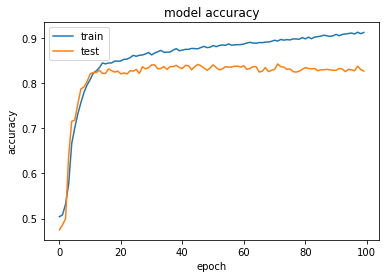

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [93]:
pred_results = model.predict(([inputs_test, questions_test]))

### Manualy validate some examples

In [94]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [95]:
test_data[0][1]

['Is', 'John', 'in', 'the', 'kitchen', '?']

In [96]:
test_data[0][2]

'no'

In [99]:
val_max = np.argmax(pred_results[0])
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key
k

'no'

It seems to be working!

In [100]:
pred_results[0][val_max]

0.99998367

It is 99% sure the answer is no.

### Create a new story to play with
We only are allowed to use words within the vocabulary we trained the model as these are the only words it knows.

In [101]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [108]:
my_story = "Sandra left the office . Daniel went to the kitchen"
my_question = "Is Daniel in the office ?"

In [109]:
my_data = [(my_story.split(), my_question.split(), 'yes')]
my_data

[(['Sandra',
   'left',
   'the',
   'office',
   '.',
   'Daniel',
   'went',
   'to',
   'the',
   'kitchen'],
  ['Is', 'Daniel', 'in', 'the', 'office', '?'],
  'yes')]

In [110]:
my_story, my_question, my_answer = vectorize_stories(my_data, tokenizer.word_index, max_story_len, max_question_len)

In [111]:
pred_results = model.predict([my_story, my_question])
val_max = np.argmax(pred_results[0])
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key
k

'yes'